# Towards engineering of reciprocal systems 

In this notebook we introduce the accounting mechanism and its use in reputation and trust systems.

The reptuation algorithm is used here in a specific context: 
 - We assume an *accounting mechansim*: it guarantees discovery, convergence of information, and protects from peer slandering: misinformation on the data accounted about one node. The event is correctly recorded in the ledger, with help of two signatures from the peers.       
 - Reputation is build on a work graph: a directed weighted graph of agents interactions. An edge in a graph is a instance of interaction. The authecthicity of interation can be verified via cryptographic signatures. 
 - The work graph is kept updated with every new iteration. Each new iteration updates the value of the interaction. 


### Test workload: model of the work graph

The interaction between the agents is modeled as a directed weighted graph. We assume an arbitary model of interaction (random graph model). We test againts the following models:
1. Power law distribution: Bittorent data distriubtion, Bitcoin transaction graph
2. Random, uniform: relay nodes 

 
## 1. Trust Functions comparison

Each trust algorithm will be analyzed by these two parameters: 

1. *Informativeness* - how good can the algorithms do 2 tasks: **filtering** (identifing cheaters/freeriders etc.) and **ranking** (choosing top K).
2. *Robustness* - how can trust algorithm resists attacks and manipulation of the algorithms. Specifically, the attacks that manipulate the scores by creating fake connections and nodes. 

## 2. Information exchange and Incomplete knowledge

Each agent acts only according to known information. The information is not guaranteed to be complete. Agents periodcially exchange information with each other.

We show how partial knowledge affects the informativeness and robustness of the reputation and trust algorithms.
1. How the reputation algorithms properties change with partial knowledge? 
2. What is the minimal required information to have a useful reputation algorithm.


### Information distribution 

The information exchange is modeled as a random process. With respect to the information exchange we propose three schemes: 
1. Structured overlay: DHT-like distribution of data.
2. Unstructured overlay: gossip-like distribution of data.
3. Full broadcast with periodical partitioning. 

## Applications and Use Cases 

1. Peer-to-peer resource sharing. The agent question is: who must I serve the first? 
When there is no competition and the resource can be provided easily - share it any peer. 
If there are multiple peers and they cannot be served without a loss in quality - the agent must decide who to serve.
   + Option 1: serve the agent with best indirect reciprocity potential. Estimate the social capital of the peer and the price of payment for the requested resources. *How much can I get If I will have a edge with you?* Agents try to maximize the value of their useful social capital.
   + Option 2: Increase own potential and attractiveness. Serve to pay off with direct reciprocity. This will significantly imporve the "credit score" of the node. Agents try to minimize the credit risk and improve their score. 
2. Federated ml .
Improve the quality of the model by sharing the model with other peers and estimating the quality of each other. 
3. File/Content sharing network. 
Peers anounce IWANT and IHAVE blocks to the network. The nodes later naturally cluster each other to optimize the exchange of the blocks. 



## Input: Generate work graph


Work graph (aka contribution graph) is a network of contribution (who to who, peer-to-peer).
We consider two work graph generators: 
 - ``wg_pl``:  Power-Law, for example bittorrent content, wikipedia pages, etc. 
 - ``wg_wf``: Uniform, random - relaying information


In [2]:
from common import draw_distribution, generate_work_graph_power_law, generate_work_graph_uniform

In [3]:
N = 100 # number of peers 

wg_pl = generate_work_graph_power_law(N)
wg_uf = generate_work_graph_uniform(N)

251.01359999999994 2.0


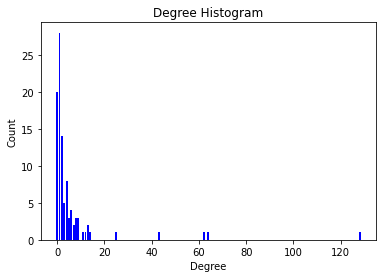

In [4]:
draw_distribution(list(dict(wg_pl.in_degree(weight='weight')).values()))

42.073599999999985 4.0


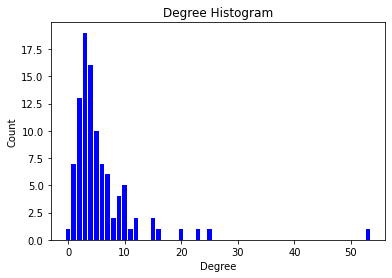

In [5]:
draw_distribution(list(dict(wg_pl.out_degree(weight='weight')).values()))

# Reputation function families 

We consider a specific subset of reputation algorithms that have the following properties: 
- Maps work graph structure to a score. The score can be ordered and every node ranked.
- Can be subjective. Provide ranking from perspective of one node. 
- Works even with partial knowledge.
- It works as an incentive to increase the contribution to the system. 
    - The nodes that contribute to the system are ranked the highest
- Stranger rule and whitewashing: 
    - The nodes for which no information is available are not ranked. 
    - There are served using special rules. 
- Anti-Freerider rules: 
    - The nodes that only consume are ranked the lowest. 
    - The more you consume the lower you rank.   

Now we need to identiy the families that satisfy the above properties.
We start testing them starting from the most basic trust function to the more complex.

Here is a list of functions we considered: 

0. Centrality-based
  - Eccentricity: Max Shortest path between two nodes. V^{-1}
  - Closeness: v = sum(d(u,v)), v^{-1}
  - Betweenness 
  - Clustering coefficient: v = sum(d(u,v))/sum(d(v,w))
  - Degree based 
  - Katz-Kernel I-tA
  - EigenCentrality 
  - Bridging 
  - Decay
  - Bonacich
1. PageRank-based: 
  - Personalized 
  - Modified with upper bounds 
2. Hitting Time based
  - Personalized 
  - Modified with upper bounds
3. Flow-based
  - Original Maxflow 
  - BarterCast  
  - Modified Batercast 
  - Netflow




# Understanding the Semantics and Choosing Parameters

To choose the parameters and build a robust and informative reputation algorithm, we need to understand the semantics of the interaction and the work/trust graph.

*Can we estimate the relative value trust connection? What about value of the nodes?*

- Is the trust transitive or not? 
- How important is the direct reciprocity?

The answer to that question depends on the system goals. 

**Case 1**. Direct connections are valued more than indirect connections.

In a extreme case, the node interacts and estimates their direct connections, for example: "Tit-for-tat".

Otherwise the indirect connections are values with respect to the direct connections.

**Case 2**. Indirect connections are more/or as valuable as direct connections.

In this case the nodes can create new connections to abuse and manipulate the system. 


### 1. Edge Semantics A -w-> B
- Resources:  A thanks B for the provided resources with "w" units. (Tipping)
- Federated Learning: Tipping for providing useful model, data etc. 

The weights of the edges can be update with the change in data or with the change in the model.

### 2. The transitivity degradation 

The further the target node is from the ego center, the less valuble it is to the ego.
Alternative formulation: The more risky the target node seems to the ego. 

The thanking and the tipping goes like a wave from the ego center to the target node.

### 3. The punishing waves 

From the ego center the target node and its tranitive neighbors are punished.
For only consuming the resources from the ego center.

### 4. The "stranger-danger"  

The nodes for which there is no information are served separately.
Basic service is provided by the ego center to the nodes with no information.


### 5. Personilization of request

Each node can requst personalized service with *IWANT* anouncements.






# Toy example

To answer all the above questions let us consider a toy example.

In [167]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_nx(G, figsize=(5,5), subtitle=None):
    pos = nx.kamada_kawai_layout(G)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    if subtitle:
        fig.suptitle(subtitle, fontweight ="bold")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    nx.draw_networkx(G, with_labels=True, 
        #connectionstyle='arc3, rad = 0.1',
        node_size=500, 
        label=15, 
        pos=pos,
        node_shape='o',
        width=1.5)
    edgeLabels = nx.get_edge_attributes(G,'weight')
    edgeLabels = {x:int(d) for x,d in edgeLabels.items()}
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edgeLabels, label_pos=0.3, font_size=10);


## Interation 1

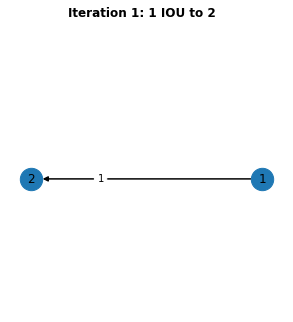

In [168]:

G1 = nx.DiGraph()
G1.add_edge(1,2, weight=1)
draw_nx(G1, subtitle='Iteration 1: 1 IOU to 2')

Let's view the trust graph from an eagle eye view. 

To understand it better consider trust network as a special form of a credit network. 
Each edge is a IOU (I owe you) relationship between nodes.

For interation 1 we create the following conditions: 
- As a result of IOU the node 1 is ranked lower than node 2


In [187]:
gt_g1 = lambda score: score(G1, 1) < score(G1, 2)

## Iteration 2

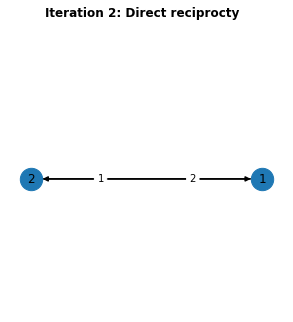

In [176]:
# Interation 2: Direct reciprocity from node 1 - node serves the node 2 

G2 = G1.copy()
G2.add_edge(2,1, weight=2)

draw_nx(G2, subtitle='Iteration 2: Direct reciprocty')

Node 1 has payed the debt and even x2 of the debt.

In [188]:
gt_g2 = lambda score: score(G2, 1) >= score(G2, 2) and \
               score(G2, 1) > score(G1, 1) and \
               score(G2, 2) < score(G1, 2) 

## Iteration 3

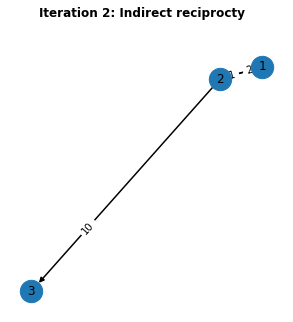

In [183]:
# Interation 3: Direct reciprocity from node 1 - node serves the node 2 

G3 = G2.copy()
G3.add_edge(2,3, weight=10)

draw_nx(G3, subtitle='Iteration 2: Indirect reciprocty')

In [189]:
gt_g3 = lambda score: score(G3, 2) < score(G2, 2) and \
               score(G3, 1) < score(G1, 1) 
               

In [186]:
rel_rep(G2, 1), rel_rep(G2, 2),

(1.0, 0.3355481727574751)

In [130]:
from ground_truth import abs_rep, rel_rep

In [140]:
rel_rep(G, 1), rel_rep(G, 2), rel_rep(G, 3)

(0.0049751243781094535, 0.3355481727574751, 1.9900990099009899)

In [138]:
abs_rep(G, 1, alpha = 1.5), abs_rep(G, 2, alpha = 1.5), abs_rep(G, 3, alpha = 1.5)

(-0.985, -0.4849999999999999, 3.0149999999999997)

In [119]:
G.add_edge(3,2, weight=0)

In [141]:
rel_rep(G, 1), rel_rep(G, 2), rel_rep(G, 3)

(0.0049751243781094535, 0.3355481727574751, 1.9900990099009899)

In [120]:
nx.pagerank(G, weight='weight')

{1: 0.1844167633067642, 2: 0.3411716203526378, 3: 0.47441161634059764}

In [123]:
nx.closeness_centrality(G, distance='weight') # Reciprocal average distance 

{1: 0.0, 2: 2.0, 3: 0.4}

In [124]:
nx.betweenness_centrality(G, weight='weight')

{1: 0.0, 2: 0.5, 3: 0.0}

### Ranking with Absolute contribution

Alpha x Total_Up - Total_Down


<AxesSubplot:title={'center':'Net Contribution'}, xlabel='Peer ranking', ylabel='Contribution value'>

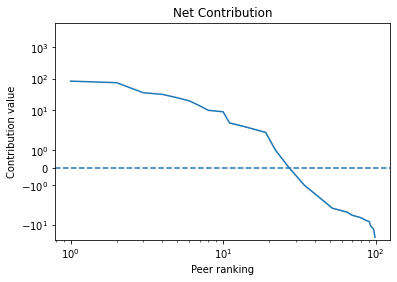

In [9]:
alpha = 1.0

G = wg_pl

gt_x = {k: abs_rep(G, k, alpha=alpha) for k in range(N)}
gt_r = rank_vals(gt_x)

draw_rank_vals(gt_x, gt_r, 'Net Contribution', ylim=(None, 6000))

### Ranking with Relative contribution

In [10]:
source_nodes = list(range(10))

#num_added_sources = 5
#source_nodes = source_nodes | {k for k in random.sample(G.nodes(), num_added_sources)}

def test_informativess(ranking_alg, gt_r, trust_rank_name = '', filter_out: bool = False, **kwargs):
    vals = []
    g = None
    for source_node in source_nodes:
        fil_func =  0 if filter_out else float('-inf')
        x = {k: max(ranking_alg.compute(source_node, k), fil_func) for k in range(N)}
        r = rank_vals(x)
        vals.append(ss.spearmanr(list(gt_r.values()), list(r.values())))

        g= draw_rank_vals(x, r, 'Contribution distribution with {}'.format(trust_rank_name), **kwargs)
        
    fig = g.get_figure()
    fig.savefig(title+".pdf") 
    

    l = [v.correlation for v in vals]
    print(np.min(l), np.mean(l), np.max(l))


### Ranking with the Trust graph

<AxesSubplot:title={'center':'Contribution distribution'}, xlabel='Peer ranking', ylabel='Contribution value'>

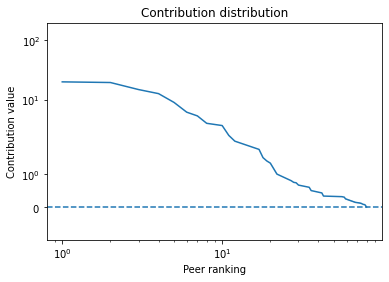

In [11]:
alpha = 1.0

gt_x = {k: rel_rep(G, k, alpha=alpha) for k in range(N)}
gt_r = rank_vals(gt_x)

draw_rank_vals(gt_x, gt_r, 'Contribution distribution', ylim=(None, max(gt_x.values()) * 10))

### Picking the source node for the experiment

In [12]:
from random import sample, seed
from typing import List

# We pick 10 at random:

def random_source_nodes(G: nx.DiGraph, n: int, seed_value: int = None) -> List[int]:
    seed(seed_value)
    return sample(G.nodes, n)


def top_donating_nodes(G: nx.DiGraph, n: int, seed_value: int = None) -> List[int]:
    top_in = sorted(((G.in_degree(i, 'weight'), i) for i in range(N)), reverse=True)[:n]
    return [k[1] for k in top_in]


def top_taking_nodes(G: nx.DiGraph, n: int, seed_value: int = None) -> List[int]:
    top_out = sorted(((G.out_degree(i, 'weight'), i) for i in range(N)), reverse=True)[:n]
    return [k[1] for k in top_out]




### Ranking with the Trust graph

In [13]:
N_range = (100, 500, 1000)

seed_node_choices = ('random', 'top_givers', 'top_takers')
rep_algos = ('pht', 'ppr', 'bc', 'rsbht', 'rspr', 'rsbhtpen')

In [14]:
results = {}

for rep in rep_algos:
    results[rep] = {}
    for s in seed_node_choices:
        results[rep][s] = {}
        for i in N_range:
            results[rep][s][i] = {}


In [15]:
results

{'pht': {'random': {100: {}, 500: {}, 1000: {}},
  'top_givers': {100: {}, 500: {}, 1000: {}},
  'top_takers': {100: {}, 500: {}, 1000: {}}},
 'ppr': {'random': {100: {}, 500: {}, 1000: {}},
  'top_givers': {100: {}, 500: {}, 1000: {}},
  'top_takers': {100: {}, 500: {}, 1000: {}}},
 'bc': {'random': {100: {}, 500: {}, 1000: {}},
  'top_givers': {100: {}, 500: {}, 1000: {}},
  'top_takers': {100: {}, 500: {}, 1000: {}}},
 'rsbht': {'random': {100: {}, 500: {}, 1000: {}},
  'top_givers': {100: {}, 500: {}, 1000: {}},
  'top_takers': {100: {}, 500: {}, 1000: {}}},
 'rspr': {'random': {100: {}, 500: {}, 1000: {}},
  'top_givers': {100: {}, 500: {}, 1000: {}},
  'top_takers': {100: {}, 500: {}, 1000: {}}},
 'rsbhtpen': {'random': {100: {}, 500: {}, 1000: {}},
  'top_givers': {100: {}, 500: {}, 1000: {}},
  'top_takers': {100: {}, 500: {}, 1000: {}}}}

## All experiments run

In [202]:
df

,Unnamed: 0,pht,ppr,bc,rsbht,rspr,rsbhtpen
0,random,"{100: [0.5878578393114711, 0.5410064751834723,...","{100: [0.5839991816597627, 0.5909847042506609,...","{100: [0.6891154479269523, 0.68511546374972, 0...","{100: [0.5173325077479654, 0.6043446539421758,...","{100: [0.5932336578396376, 0.6805248784149217,...","{100: [-0.1589882071444902, 0.4367676503611862..."
1,top_givers,"{100: [0.6259198475539121, 0.6319298291547024,...","{100: [0.6141243798746008, 0.6091184004959278,...","{100: [0.8845258533508902, 0.9377382265694498,...","{100: [0.6786302497515891, 0.6976311091200749,...","{100: [0.7142420996233849, 0.8490554379364225,...","{100: [-0.16594460875779027, -0.16943817946848..."
2,top_takers,"{100: [0.6440932763897119, 0.6178272815047784,...","{100: [0.5975472905541094, 0.5580552929196236,...","{100: [0.8640637586507732, 0.6855166020807882,...","{100: [0.5667370545622518, 0.5949601243872373,...","{100: [0.851050971799948, 0.5817377952206368, ...","{100: [-0.15893874400678323, 0.357458826975897..."


## Filtering 

Simple binary classification: 
- `< 0` balance - freerider - Get 0 
- `> 0` balance - leave as it is 



-----
## Robustness of the algorithms

We analyze the robusteness of these algorithms against sybil attacks with fake data. 



In [246]:
df_f

,pht,ppr,bc,rsbht,rspr,rsbhtpen
random,"{100: [(0.5194805194805194, 0.975609756097561,...","{100: [(0.5946666666666667, 1.0, 0.74581939799...","{100: [(0.8467532467532467, 0.9235127478753541...","{100: [(0.6271604938271605, 0.9694656488549618...","{100: [(0.8805555555555555, 0.9057142857142857...","{100: [(0.8971428571428571, 0.814526588845655,..."
top_givers,"{100: [(0.5063291139240507, 1.0, 0.67226890756...","{100: [(0.5945945945945946, 0.9777777777777777...","{100: [(0.9987012987012988, 0.853496115427303,...","{100: [(0.7794871794871795, 0.9514866979655712...","{100: [(0.970886075949367, 0.8437843784378438,...","{100: [(0.9947368421052631, 0.7605633802816901..."
top_takers,"{100: [(0.7692307692307693, 0.9966777408637874...","{100: [(0.4797297297297297, 1.0, 0.64840182648...","{100: [(0.78125, 0.9384384384384384, 0.8526603...","{100: [(0.7680555555555556, 0.9388794567062818...","{100: [(0.7577464788732394, 0.8663446054750402...","{100: [(0.9056338028169014, 0.7564705882352941..."


## Visualizing results 

In [ ]:
### We visualize 

In [251]:
df_f['pht']['random']

[(0.5194805194805194, 0.975609756097561, 0.6779661016949152),
 (0.6093333333333333, 1.0, 0.7572493786246892),
 (0.6092105263157894, 0.9605809128630706, 0.7455716586151369),
 (0.551948051948052, 1.0, 0.7112970711297071),
 (0.396, 1.0, 0.5673352435530087)]

In [372]:
m_df[m_df['source'] == 'random']

,source,alg,g_n,precision,recall,f1
0,random,pht,100,0.537194,0.987238,0.691884
1,random,pht,500,0.674737,0.963045,0.792483
2,random,pht,1000,0.718318,0.950568,0.818018
3,random,ppr,100,0.601295,0.983462,0.736123
4,random,ppr,500,0.603716,0.983250,0.746154
5,random,ppr,1000,0.572223,0.982441,0.722611
6,random,bc,100,0.831093,0.904981,0.864739
7,random,bc,500,0.752627,0.918076,0.825838
8,random,bc,1000,0.738564,0.922337,0.818842
9,random,rsbht,100,0.717865,0.922818,0.805439


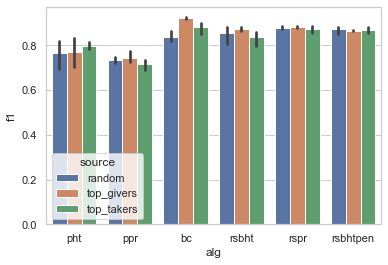

In [382]:
tips = m_df
ax = sns.barplot(x="alg", y="f1", data=tips, hue='source')

# Next notebooks 

**Informativeness**:
- Testing reputation algorithms as a *Ranking algorithms*  
- Testing reputation algorithms as a *Filtering algorithms*

**Robustness**:
- Testing reputation algorithms for Robustness: One attacker with a Sybil

**Imperfect Knowledge**:
- Info


